In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
%pip install h5py
%pip install typing-extensions
%pip install wheel

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install tensorflow==2.10.0


Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install tensorflow-gpu==2.10.0 


Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.


In [8]:
%pip install dash==1.20.0 

Note: you may need to restart the kernel to use updated packages.


In [6]:
#importing standard dependencies
import numpy as np
import cv2
import random
import os
from matplotlib import pyplot as plt

In [7]:
#import tensorflow dependencies- Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf


Set GPU Growth

In [9]:
#Avoid OOM errors by setting GPU Memory Consumption Growth
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

Creating folder structures

In [10]:
#Setup paths
POS_PATH =os.path.join('data', 'positive')
NEG_PATH =os.path.join('data', 'negative')
ANC_PATH =os.path.join('data', 'anchor')

In [11]:
#Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

Part 2
Collect Positive and Anchor classes

2.1 Untar Labelled faces

In [ ]:
!tar -xf lfw.tgz

: 

In [13]:
#Move LFW Images to the following directory data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH= os.path.join("lfw",directory, file)
        NEW_PATH= os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [12]:
#Importing uuid to generate unique identifiers for the captured pictures
import uuid

Collect Positive and Anchor Classes

In [14]:
#Establish a connection to the webcam
cap= cv2.VideoCapture(2)

#Loops through every single frame in the webcam
while cap.isOpened():

    ret, frame = cap.read()

    
    #cut down frame to 250x250px
    frame=frame[120:120+250,200:200+250, :]
    
    #collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        
        #Creates the unique name 
        imgname=os.path.join(ANC_PATH, '{}..jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
        
    #collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        
        #Creates the unique name 
        imgname=os.path.join(POS_PATH, '{}..jpg'.format(uuid.uuid1()))
        #Write out positive image
        cv2.imwrite(imgname, frame)
    
    #shows the image back to the screen
    cv2.imshow('Image Collection', frame)
    
    #checks after 1 millisecond and if the key 'q' has been pressed
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
cap.release
cv2.destroyAllWindows()

Part 3
3.1 Get Image directories

In [15]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [16]:
import os
import uuid

In [ ]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

KeyboardInterrupt: 

In [22]:
#This part grabs all of our image directories
anchor= tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000)
positive= tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
negative= tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)


In [18]:
dir_test= anchor.as_numpy_iterator()
print(dir_test.next())

Preprocessing- Scale and Size

In [19]:
#This part preprocesses all the images in part 3.1
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img=tf.io.decode_jpeg(byte_img)
    img=tf.image.resize(img, (105,105))
    img = img/255.0
    return img

In [20]:
#dataset.map(preprocess)

Create a labelled dataset

In [23]:
#This then creates the labelled dataset
#for positives it should return a numpy array of 1s
#for negatives it should return a numpy array of 0s

positives=tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives=tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
data= positives.concatenate(negatives)

In [24]:
samples= data.as_numpy_iterator()

In [25]:
samples.next()

(b'data\\anchor\\8f9752d0-4c06-11ed-ad7e-b4b52f8bb417..jpg',
 b'data\\positive\\912b1ced-5d32-11ed-83fc-b4b52f8bb417.jpg',
 1.0)

3.4 Build Train and Test Partition

In [26]:
#this then preprocesses the twins
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [27]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=4024)

In [28]:
#Training Partition
train_data= data.take(round(len(data)*0.7))

#we are taking our training data in batches of 16 meaning 16 pics per batch
train_data= train_data.batch(16)
train_data= train_data.prefetch(8)

In [29]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [30]:
inp=Input(shape=(105,105,3), name='input_image')


In [31]:
inp

<KerasTensor: shape=(None, 105, 105, 3) dtype=float32 (created by layer 'input_image')>

In [32]:
c1=Conv2D(64,(10,10), activation='relu')(inp)
m1=MaxPooling2D(64, (2,2), padding='same')(c1)


In [33]:
c1

<KerasTensor: shape=(None, 96, 96, 64) dtype=float32 (created by layer 'conv2d')>

In [34]:
m1

<KerasTensor: shape=(None, 48, 48, 64) dtype=float32 (created by layer 'max_pooling2d')>

In [35]:
c2=Conv2D(128,(7,7), activation='relu')(m1)
m2=MaxPooling2D(64, (2,2), padding='same')(c2)
    

In [36]:
c2

<KerasTensor: shape=(None, 42, 42, 128) dtype=float32 (created by layer 'conv2d_1')>

In [37]:
m2

<KerasTensor: shape=(None, 21, 21, 128) dtype=float32 (created by layer 'max_pooling2d_1')>

In [38]:
c3=Conv2D(128,(4,4), activation='relu')(m2)
m3=MaxPooling2D(64, (2,2), padding='same')(c3)
    

In [39]:
c3

<KerasTensor: shape=(None, 18, 18, 128) dtype=float32 (created by layer 'conv2d_2')>

In [40]:
m3

<KerasTensor: shape=(None, 9, 9, 128) dtype=float32 (created by layer 'max_pooling2d_2')>

In [41]:
c4=Conv2D(256,(4,4), activation='relu')(m3)
f1= Flatten()(c4)
d1= Dense(4096, activation='sigmoid')(f1)
    

In [42]:
c4

<KerasTensor: shape=(None, 6, 6, 256) dtype=float32 (created by layer 'conv2d_3')>

In [43]:
f1

<KerasTensor: shape=(None, 9216) dtype=float32 (created by layer 'flatten')>

In [44]:
d1

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'dense')>

In [45]:
mod= Model(inputs=[inp], outputs=[d1], name='embedding')
mod

In [46]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

4. Model Engineering

4.1 Build Embedding Layer

In [47]:
def make_embedding():
    inp=Input(shape=(105,105,3), name='input_image')
    
    #First Block
    c1=Conv2D(64,(10,10), activation='relu')(inp)
    m1=MaxPooling2D(64, (2,2), padding='same')(c1)

    #Second Block
    c2=Conv2D(128,(7,7), activation='relu')(m1)
    m2=MaxPooling2D(64, (2,2), padding='same')(c2)
    
    #Third Block
    c3=Conv2D(128,(4,4), activation='relu')(m2)
    m3=MaxPooling2D(64, (2,2), padding='same')(c3)
    
    #Final Embedding Block
    c4=Conv2D(256,(4,4), activation='relu')(m3)
    f1= Flatten()(c4)
    d1= Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')



In [48]:
embedding= make_embedding()

In [49]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 18, 18, 128)       26

Build Distance Layer

In [50]:
#Siamese L1 Distance class
class L1Dist(Layer):

    #Init method - Inheritance
    def __init__(self, **kwargs):
        super().__init__()

    #Does the similarity culculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [51]:
l1= L1Dist()

In [52]:
l1

4.3 Make Siamese Model

In [53]:
input_image= Input(name='input_img', shape=(105,105,3))
validation_image= Input(name='validation_image', shape=(105,105,3))

In [54]:
val_embedding=embedding(validation_image)
inp_embedding=embedding(input_image)

In [55]:
val_embedding
inp_embedding

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [56]:
siamese_layer= L1Dist()

In [57]:
distances= siamese_layer(inp_embedding, val_embedding)

In [58]:
classifier= Dense(1, activation= 'sigmoid')(distances)

In [59]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [60]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name= 'SiameseNetwork')

In [61]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_image (InputLayer)  [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['validation_image[0][0]',       
                                                                  'input_img[0][0]'] 

In [62]:
def make_siamese_model():

    #Anchgor image input
    input_image= Input(name='input_img', shape=(105,105,3))

    #Validation Image in the network
    validation_image = Input(name='validation_img', shape=(105,105,3))

    #Combine the Siamese Distance Components
    siamese_layer= L1Dist()
    siamese_layer._name= 'distance'
    distances= siamese_layer(embedding(input_image), embedding(validation_image))

    #Classification layer
    classifier= Dense(1, activation= 'sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name= 'SiameseNetwork')


In [63]:
siamese_model= make_siamese_model()

In [64]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

5. Training

5.1 Setup loss and Optimizer

In [65]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [66]:
opt = tf.keras.optimizers.Adam(1e-4) 

5.2 Establish Checkpoints

In [67]:
checkpoint_dir= './training_checkpoints'
checkpoint_prefix= os.path.join(checkpoint_dir, 'ckpt')
checkpoint= tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

Build Train Step Function


In [68]:
test_batch = train_data.as_numpy_iterator()

In [69]:
batch_1 = test_batch.next()

In [70]:
X = batch_1[:2]

In [71]:
y = batch_1[2]

In [72]:
y

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)

In [ ]:
tf.losses.BinaryCrossentropy??

Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='auto',
    name='binary_crossentropy',
)
Source:        
@keras_export("keras.losses.BinaryCrossentropy")
class BinaryCrossentropy(LossFunctionWrapper):
    """Computes the cross-entropy loss between true labels and predicted labels.

    Use this cross-entropy loss for binary (0 or 1) classification applications.
    The loss function requires the following inputs:

    - `y_true` (true label): This is either 0 or 1.
    - `y_pred` (predicted value): This is the model's prediction, i.e, a single
      floating-point value which either represents a
      [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
      when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
      `from_logits=False`).

    **Recommended Usage:** (set `from_logits=True`)

    With `tf.keras` API:

    ```python
    model.compile(
      loss=tf.keras.losses

In [73]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [74]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [75]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [76]:
EPOCHS = 50

In [ ]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 2027s 61s/step
0.0014200557 1.0 1.0

 Epoch 2/50
27/27 [==============================] - 1627s 60s/step
5.220028e-05 1.0 1.0

 Epoch 3/50
27/27 [==============================] - 1564s 58s/step
1.1146154e-05 1.0 1.0

 Epoch 4/50
27/27 [==============================] - 1599s 59s/step
8.985451e-06 1.0 1.0

 Epoch 5/50
27/27 [==============================] - 1583s 58s/step
4.917397e-06 1.0 1.0

 Epoch 6/50
27/27 [==============================] - 1587s 59s/step
3.3825734e-06 1.0 1.0

 Epoch 7/50
27/27 [==============================] - 1706s 63s/step
2.7269205e-06 1.0 1.0

 Epoch 8/50
27/27 [==============================] - 2529s 94s/step
2.3813081e-05 1.0 1.0

 Epoch 9/50
27/27 [==============================] - 1578s 58s/step
7.8976205e-07 1.0 1.0

 Epoch 10/50
27/27 [==========

In [ ]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [ ]:
test_var=test_data.as_numpy_iterator().next()

In [ ]:
len(test_var[0])

16

In [ ]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 32s 32s/step


In [ ]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
y_true

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)

In [ ]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.0

In [ ]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.0

In [ ]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 4s 4s/step
0.0 0.0


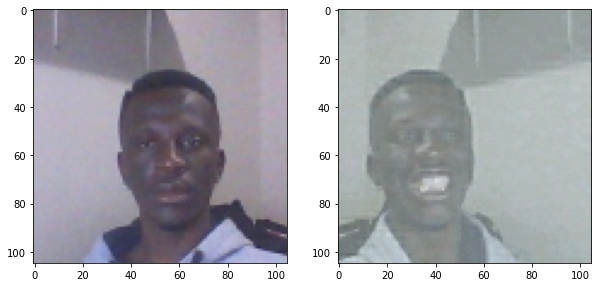

In [ ]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [ ]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [ ]:
L1Dist

__main__.L1Dist

In [ ]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [ ]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 11s 11s/step


array([[0.49027094],
       [0.49067906],
       [0.49025974],
       [0.49045768]], dtype=float32)

In [ ]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [ ]:
application_data\verification_images

In [ ]:
os.listdir(os.path.join('application_data', 'verification_images'))

[]

In [ ]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [ ]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

In [ ]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

TypeError: 'NoneType' object is not subscriptable

In [ ]:
np.sum(np.squeeze(results) > 0.9)

NameError: name 'results' is not defined

In [ ]:
results